In [70]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2


from htmresearch.support.autoencoder.lateral_k_sparse_autoencoder import LateralKSparseAutoencoder

params = {
    "num_inputs": 28**2,
    "num_outputs": 100,
    "code_weight": 1,
    "learning_rate": 0.1,
    "beta": 0.001,
    "enforce_binary_output": False,
    "enable_boosting"      : True,
    "enforce_code_weight"  : False,
    "with_lateral"         : True,
    "fixed_lateral_connections": True
}

sp = LateralKSparseAutoencoder(**params)
print sp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

**Lateral k-sparse autoencoder:**
------------------
Number of inputs (m):	 784
Number of outputs (n):	 100
Code weight (k):	 1
Sparsity (k/n):		 0.01
Beta:			 0.001
Learning rate:		 0.1
Min/Max weights :	 -3.89  |  +4.40
Binary outupt:		 False
Boosting:		 True
Lateral:		 True
Enforce code weight:	 False
------------------


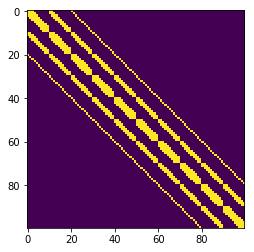

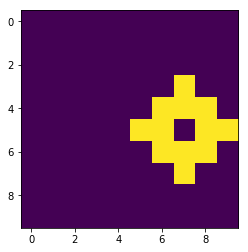

In [71]:
from itertools import product
n = sp.num_outputs
L = np.zeros((n,n))

img = np.zeros((10,10))

for (p1, p2) in product(range(10), repeat=2):
    for (q1, q2) in product(range(10), repeat=2):
        dist = np.sqrt((p1-q1)**2 + (p2-q2)**2)
        L[p1*10 + p2, q1*10 + q2] = np.exp( - dist**2/2.5  )

L -= np.amin(L)
L /= np.amax(L)

L = (L > 0.2).astype(float)

# L = np.ones((n,n))
plt.imshow(L )
plt.show()


sp._updateLateralConnections(L)

plt.imshow(sp.lateral_connections[np.random.choice(n)].reshape((10,10)))
plt.show()


0
1
2


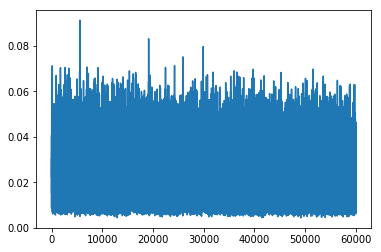

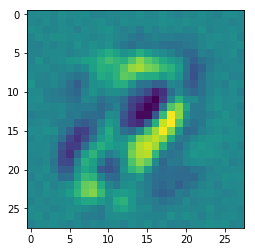

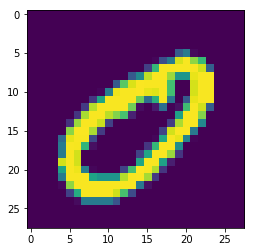

In [72]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata
from sklearn.neural_network import MLPClassifier

mnist = fetch_mldata("MNIST original")
# rescale the data, use the traditional train/test split
X, y = mnist.data / 255., mnist.target

X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]



d = 60000
for i in range(3):
    print i
    perm = np.random.permutation(len(X_train))
    Y, E, L = sp.fit(X_train[perm][:d])

plt.plot(L)
plt.show()
plt.imshow(sp.weights[1].reshape(28,28))
plt.show()
plt.imshow(X_train[perm][0].reshape(28,28))


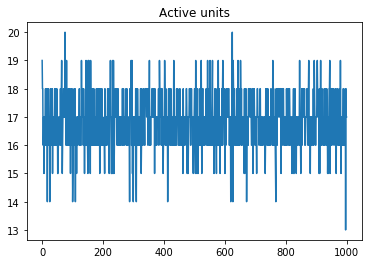

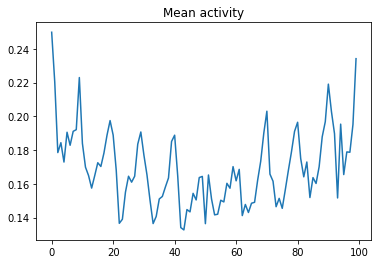

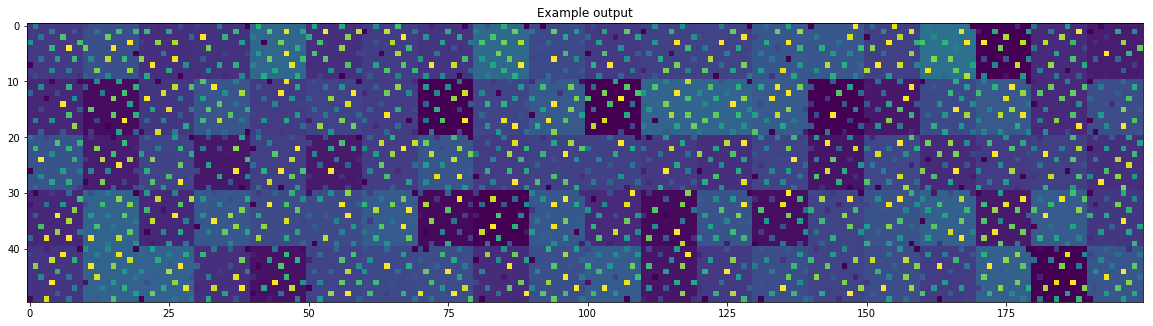

10
10
(280, 280)


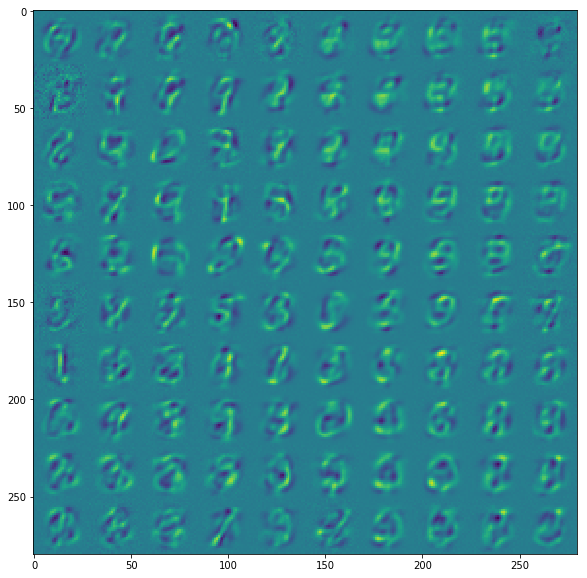

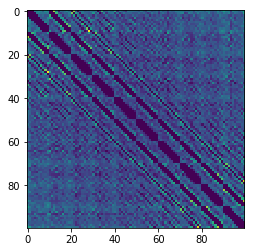

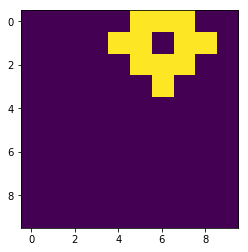

In [73]:
from scipy.special import expit as sigmoid


def normalize(x):
    x = x - np.amin(x)
    x = x/np.amax(x)
    return x


def block_image(W, w, h, s):
    w = 20
    h = 5
    num_samples = w*h
    sample_units = np.random.choice(len(W), size=num_samples, replace=False) 



    img_matrix = []
    for y in range(h):
        img_matrix.append([])
        for x in range(w):
            i = sample_units[y*w + x]
            img = W[i].reshape(s,s)
            img = normalize(img)
            img_matrix[-1].append(img)

    img = np.concatenate([ np.concatenate(row, axis=1) for row in img_matrix], axis=0)
    return img



Y_ = sp.encode(X_train[perm][:1000], enforce_binary_output=True)
plt.title("Active units")
plt.plot(np.sum(Y_,axis=1))
plt.show()

W = sp.weights
k = sp.code_weight
t=-1


plt.title("Mean activity")
plt.plot(sp.mean_activity)
plt.show()

img = block_image(Y, 20,10,10)

plt.figure(figsize=(20,10))
plt.title("Example output")
plt.imshow(img)
plt.show()

f = 10
n = sp.num_outputs
W = sp.weights
img_matrix = [[ W[i*n//f + j].reshape(28,28) for j in range(n//f) ]    for i in range(f)]

# img_matrix = [[ img - np.amin(img) for img in row ] for row in img_matrix ]
# img_matrix = [[ img/np.amax(img) for img in row ] for row in img_matrix ]

print len(img_matrix)
print len(img_matrix[0])

img = np.concatenate([ np.concatenate(row, axis=1) for row in img_matrix], axis=0)

plt.figure(figsize=(100,10))
print img.shape
plt.imshow(img)

plt.show()
Avg = sp.avgActivityPairs
np.fill_diagonal(Avg, 0.0)
plt.imshow(Avg)
plt.show()

plt.imshow(sp.lateral_connections[np.random.choice(n)].reshape((10,10)))
plt.show()


## 

In [52]:


per = np.random.permutation(len(X_test))
print sp


**Lateral k-sparse autoencoder:**
------------------
Number of inputs (m):	 784
Number of outputs (n):	 100
Code weight (k):	 5
Sparsity (k/n):		 0.05
Beta:			 0.001
Learning rate:		 0.1
Min/Max weights :	 -0.27  |  +0.24
Binary outupt:		 False
Boosting:		 True
Lateral:		 True
Enforce code weight:	 False
------------------


20.6821796378
71.4108095407


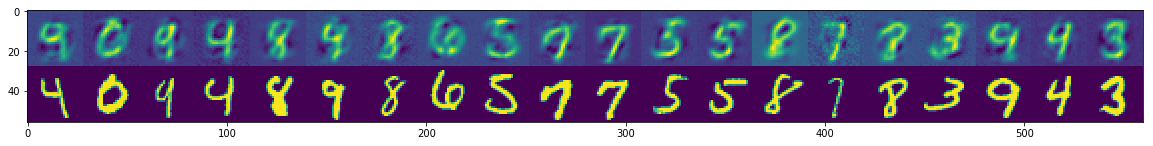

In [53]:

T = 10000
Y_test  = sp.encode(X_test[per][:T], with_boosting=True, with_lateral=True, enforce_binary_output=False)


X_hat  =  np.dot(Y_test, sp.weights)



print np.sum((X_hat[:T] - X_test[per][:T])**2)/T
print np.sum(np.abs(X_hat[:T] - X_test[per][:T]))/T



img_matrix = []
for i in range(20):
    x = normalize(X_test[per][i])
    x_hat = normalize(X_hat[i])

    
    img_matrix.append([ x_hat.reshape((28,28)).T, x.reshape((28,28)).T])

img = np.concatenate([ np.concatenate(row, axis=1) for row in img_matrix], axis=0)

plt.figure(figsize=(20,10))
plt.imshow(img.T)

(140, 560)


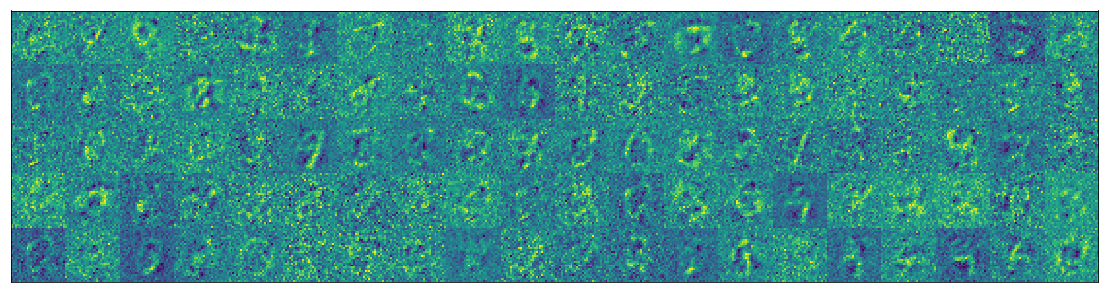

In [16]:
w = 20
h = 5
num_samples = w*h
n = sp.num_outputs
sample_units = np.random.choice(n, size=num_samples, replace=False) 




W = sp.weights

img_matrix = []
for y in range(h):
    img_matrix.append([])
    for x in range(w):
        i = sample_units[y*w + x]
        img = W[i].reshape(28,28)
        img = normalize(img)
        img_matrix[-1].append(img)

img = np.concatenate([ np.concatenate(row, axis=1) for row in img_matrix], axis=0)

plt.figure(figsize=(20,5))
print img.shape
plt.xticks([])
plt.yticks([])
plt.imshow(img)
plt.savefig("non-boosted_feature_sample.pdf")